# Process ML Model

### Load Training and Testing datasets

In [2]:
import numpy as np
import pandas as pd

#Load all training data
X_train = pd.read_csv('Inputs\\train_test_sets\\training.csv')
y_train = X_train.pop('Label')
print(X_train.shape)

#Load all testing data
X_test = pd.read_csv('Inputs\\train_test_sets\\testing.csv')
y_test = X_test.pop('Label')
print(X_test.shape)

(999856, 71)
(1499016, 71)


In [102]:
print('Shape of Training Set:', X_train.shape)
print('Shape of Testing Set:', X_test.shape)
dist = pd.DataFrame()
dist['y_train Freq'] = y_train.value_counts()
dist['y_train %'] = y_train.value_counts(normalize=True)
dist['y_test Freq'] = y_test.value_counts()
dist['y_test %'] = y_test.value_counts(normalize=True)
dist.style.format("{:.3%}", subset=['y_train %', 'y_test %'])

Shape of Training Set: (999856, 69)
Shape of Testing Set: (1499016, 69)


,y_train Freq,y_train %,y_test Freq,y_test %
Label,,,,
DoS attacks-Hulk,164962,16.499%,115478,7.704%
DDOS attack-HOIC,156456,15.648%,171503,11.441%
DDoS attacks-LOIC-HTTP,151250,15.127%,144048,9.610%
Bot,129813,12.983%,71548,4.773%
Benign,121965,12.198%,847255,56.521%
Infilteration,120476,12.049%,40160,2.679%
SSH-Bruteforce,84521,8.453%,46897,3.129%
DoS attacks-GoldenEye,31131,3.114%,10377,0.692%
FTP-BruteForce,29045,2.905%,48339,3.225%


### Commence Training

#### Training using an unbalanced dataset - Just using Class Weights on Classifier

Note: The chosen classifier is LGBMClassifier. As this is a tree based classifier, we will not be scaling the training set data. Hence there is not much benefit in using a StandardScaler or a MaxMinScaler to normalise the data (most tree-based classifiers to not require any scaling of data). Also we will not be doing any encoding of categorical features (as we discovered towards the end of the Evaluate Models.ipynb, the only categorical features of the dataset, Protocol and Dst Port Class, are not seen as "important" for this classifier.
This implies it is not work using a pipleline feature of sklearn. We will simply drop the Protocol and Dst Port Class features and simple fit the classifier.

Given the dataset is higly unbalanced, we need to evaluate the impact of this and what strategies we can use to get the best out of the LightGBM classifier. First, we'll try using just class weights on the classifer

In [106]:
X_train.shape

(999856, 71)

In [107]:
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, fbeta_score, matthews_corrcoef

#drop features that are not required
features_to_drop = ['Protocol', 'Dst Port Class']
X_train.drop(axis=1, columns=features_to_drop, inplace=True)
X_test.drop(axis=1, columns=features_to_drop, inplace=True)

#Encode the target classes
labelEnc = LabelEncoder()
y_train = pd.Series(labelEnc.fit_transform(y_train), index=y_train.index)
y_test =  pd.Series(labelEnc.fit_transform(y_test), index=y_test.index)

#define the classifier
clf = LGBMClassifier(class_weight='balanced', objective='multiclass', n_jobs=-1, verbose=-1)

#Run the pipeline
clf.fit(X_train, y_train)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train.shape)
print('Training Set: F2 score: ', fbeta_score(y_train, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))


Training Set: Size:  (999856, 69)
Training Set: F2 score:  0.9782897110451056
Training Set: Matthews Correlation Coefficient:  0.9765964478000423

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.8818881025411921
Testing Set: Matthews Correlation Coefficient:  0.9075697660210742


    precision  recall  f2-score  support
0        1.00    0.88      0.90  847,255
1        1.00    1.00      1.00   71,548
2        0.13    0.95      0.42      153
3        0.77    0.93      0.89       57
4        1.00    1.00      1.00  171,503
5        0.76    0.98      0.93      432
6        1.00    1.00      1.00  144,048
7        1.00    1.00      1.00   10,377
8        1.00    1.00      1.00  115,478
9        0.99    1.00      1.00    2,747
10       1.00    1.00      1.00   48,339
11       0.28    0.93      0.63   40,160
12       0.26    0.82      0.57       22
13       1.00    1.00      1.00   46,897

Matthews Correlation Coefficient:  0.91
F2 Macro score:  88.2%
None


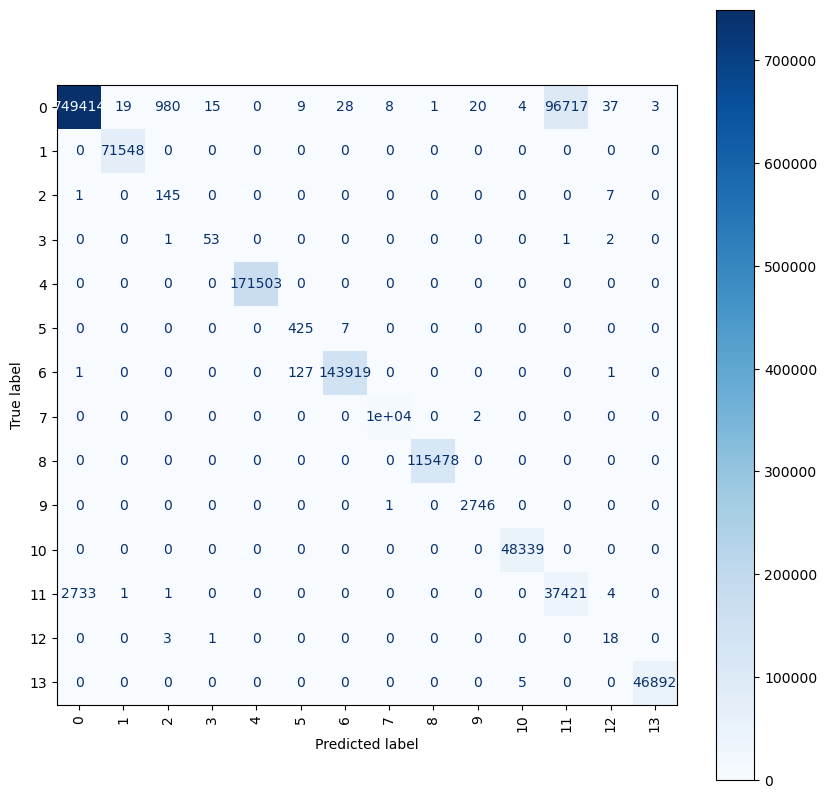

In [117]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from CustomFunctions import classification_report_IDS
import matplotlib.pyplot as plt

#Plot the confusion matrix
c = ConfusionMatrixDisplay(confusion_matrix(y_test, pred_test), display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(10,10))
c.plot(ax = ax, cmap='Blues', xticks_rotation='vertical')

## Classification Report
cReport = classification_report_IDS(y_test, pred_test)
print(cReport)

### Run Experiments

#### Training after balancing dataset - RandomUnderSampler and RandomOverSampler

In [118]:
from collections import Counter
Counter(y_train)

Counter({8: 164962,
         4: 156456,
         6: 151250,
         1: 129813,
         0: 121965,
         11: 120476,
         13: 84521,
         7: 31131,
         10: 29045,
         9: 8243,
         5: 1298,
         2: 458,
         3: 173,
         12: 65})

In [137]:
#Undersample with RandomUnderSampler for imbalanced dataset
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

#Define the over sampling and under sampling ratios
dictUnderSample = {  8: 50000,
                    4: 50000,
                    6: 50000,
                    1: 50000,
                    0: 50000,
                    11: 50000,
                    13: 50000,
                    7: 31131,
                    10: 29045,
                    9: 8243,
                    5: 1298,
                    2: 458,
                    3: 173,
                    12: 65}

dictOverSample = {  8: 50000,
                    4: 50000,
                    6: 50000,
                    1: 50000,
                    0: 50000,
                    11: 50000,
                    13: 50000,
                    7: 50000,
                    10: 50000,
                    9: 50000,
                    5: 50000,
                    2: 50000,
                    3: 50000,
                    12: 50000}

pipeline = Pipeline(steps=[ ('underSample', RandomUnderSampler(random_state=0, sampling_strategy=dictUnderSample)),
                            ('overSample', RandomOverSampler(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)

In [135]:
y_train2.value_counts()

0     50000
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
10    50000
11    50000
12    50000
13    50000
Name: count, dtype: int64

In [138]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, fbeta_score
import time

#define the classifier
clf = LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1)

#Run the pipeline
clf.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train2)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2 score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))


Training Set: Size:  (700000, 69)
Training Set: F2 score:  0.9858786118969656
Training Set: Matthews Correlation Coefficient:  0.9848306331684265

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.9037705527050672
Testing Set: Matthews Correlation Coefficient:  0.9014379101484135


#### Training after balancing dataset - Nearmiss and SMOTE

In [143]:
from collections import Counter
Counter(y_train)

Counter({8: 164962,
         4: 156456,
         6: 151250,
         1: 129813,
         0: 121965,
         11: 120476,
         13: 84521,
         7: 31131,
         10: 29045,
         9: 8243,
         5: 1298,
         2: 458,
         3: 173,
         12: 65})

In [145]:
#Undersample with NearMiss 
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

#Undersample and the oversample
pipeline = Pipeline(steps=[ ('underSample', NearMiss(version=2, sampling_strategy=dictUnderSample)),
                            ('overSample', SMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
y_train2.value_counts()

0     50000
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
10    50000
11    50000
12    50000
13    50000
Name: count, dtype: int64

In [146]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, fbeta_score

#define the classifier
clf = LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1)

#Run the pipeline
clf.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train2)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2 score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))



Training Set: Size:  (700000, 69)
Training Set: F2 score:  0.9851208580046416
Training Set: Matthews Correlation Coefficient:  0.9841996432234474

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.6880689797513871
Testing Set: Matthews Correlation Coefficient:  0.7687052648540399


#### Training after balancing dataset - RandomUnderSampler and SMOTE

In [147]:
from collections import Counter
Counter(y_train)

Counter({8: 164962,
         4: 156456,
         6: 151250,
         1: 129813,
         0: 121965,
         11: 120476,
         13: 84521,
         7: 31131,
         10: 29045,
         9: 8243,
         5: 1298,
         2: 458,
         3: 173,
         12: 65})

In [148]:
#Undersample with RandomUndersampler for imbalanced dataset
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

pipeline = Pipeline(steps=[ ('underSample', RandomUnderSampler(random_state=0, sampling_strategy=dictUnderSample)),
                            ('overSample', SMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
y_train2.value_counts()

0     50000
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
10    50000
11    50000
12    50000
13    50000
Name: count, dtype: int64

In [149]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, fbeta_score, matthews_corrcoef
from CustomFunctions import Timer

#define the classifier
clf = LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1)

#Train the classifier
clf.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train2)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2_Macro score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2_Macro score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')



Training Set: Size:  (700000, 69)
Training Set: F2_Macro score:  0.9854879107057679
Training Set: Matthews Correlation Coefficient:  0.9844036283536937

Testing Set: Size:  (1499016, 69)
Testing Set: F2_Macro score:  0.8887335827485824
Testing Set: Matthews Correlation Coefficient:  0.9027174066846889




#### Training after balancing dataset - RandomUnderSampler and BorderlineSMOTE

In [150]:
from collections import Counter
Counter(y_train)

Counter({8: 164962,
         4: 156456,
         6: 151250,
         1: 129813,
         0: 121965,
         11: 120476,
         13: 84521,
         7: 31131,
         10: 29045,
         9: 8243,
         5: 1298,
         2: 458,
         3: 173,
         12: 65})

dict

In [156]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

#Pipeline for undersampling and then oversampling
pipeline = Pipeline(steps=[ ('underSample', RandomUnderSampler(random_state=0, sampling_strategy=dictUnderSample)),
                            ('overSample', BorderlineSMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
y_train2.value_counts()

0     50000
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
11    50000
12    50000
13    50000
10    29045
Name: count, dtype: int64

In [157]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, fbeta_score, matthews_corrcoef
from CustomFunctions import Timer

#Define the classifier
clf = LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1)

#Run the pipeline
clf.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train2)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2 score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')



Training Set: Size:  (679045, 69)
Training Set: F2 score:  0.9822112087477219
Training Set: Matthews Correlation Coefficient:  0.9802750522462694

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.9101498165506738
Testing Set: Matthews Correlation Coefficient:  0.9040854097498818




#### Training after balancing dataset - NearMiss (ver1) and BorderlineSMOTE

In [158]:
from collections import Counter
Counter(y_train)

Counter({8: 164962,
         4: 156456,
         6: 151250,
         1: 129813,
         0: 121965,
         11: 120476,
         13: 84521,
         7: 31131,
         10: 29045,
         9: 8243,
         5: 1298,
         2: 458,
         3: 173,
         12: 65})

In [159]:
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

#Pipeline for undersampling and then oversampling
pipeline = Pipeline(steps=[ ('underSample', NearMiss(version=1, sampling_strategy=dictUnderSample)),
                            ('overSample', BorderlineSMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
y_train2.value_counts()

0     50000
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
11    50000
12    50000
13    50000
10    29045
Name: count, dtype: int64

In [162]:
from lightgbm import LGBMClassifier
from sklearn.metrics import fbeta_score, matthews_corrcoef

#Define the classifier
clf = LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1)

#Train the classifier
clf.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train2)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2 score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')



Training Set: Size:  (679045, 69)
Training Set: F2 score:  0.40008735326440814
Training Set: Matthews Correlation Coefficient:  0.41343387964378053

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.3110688607848441
Testing Set: Matthews Correlation Coefficient:  0.3017623143131098




#### Training after balancing dataset - NearMiss (ver2) and BorderlineSMOTE

In [163]:
from collections import Counter
Counter(y_train)

Counter({8: 164962,
         4: 156456,
         6: 151250,
         1: 129813,
         0: 121965,
         11: 120476,
         13: 84521,
         7: 31131,
         10: 29045,
         9: 8243,
         5: 1298,
         2: 458,
         3: 173,
         12: 65})

In [164]:
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

#Pipeline for undersampling and then oversampling
pipeline = Pipeline(steps=[ ('underSample', NearMiss(version=2, sampling_strategy=dictUnderSample)),
                            ('overSample', BorderlineSMOTE(random_state=0, sampling_strategy=dictOverSample)) ])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
y_train2.value_counts()

0     50000
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
11    50000
12    50000
13    50000
10    29045
Name: count, dtype: int64

In [165]:
from lightgbm import LGBMClassifier
from sklearn.metrics import fbeta_score, matthews_corrcoef

#Define the classifier
clf = LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1)

#Run the pipeline
clf.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train2)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2 score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')



Training Set: Size:  (679045, 69)
Training Set: F2 score:  0.9823469575821839
Training Set: Matthews Correlation Coefficient:  0.9806460073280666

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.6041997539547443
Testing Set: Matthews Correlation Coefficient:  0.6309059927393734




#### Training after partially balancing dataset - RandomUnderSampler and Class Weights on classifier

In [166]:
from collections import Counter
Counter(y_train)

Counter({8: 164962,
         4: 156456,
         6: 151250,
         1: 129813,
         0: 121965,
         11: 120476,
         13: 84521,
         7: 31131,
         10: 29045,
         9: 8243,
         5: 1298,
         2: 458,
         3: 173,
         12: 65})

In [168]:
#Undersample with RandomUnderSampler 
from imblearn.under_sampling import RandomUnderSampler

pipeline = Pipeline(steps=[ ('underSample', RandomUnderSampler(random_state=0, sampling_strategy=dictUnderSample))])

#Run the pipeline
X_train2, y_train2 = pipeline.fit_resample(X_train, y_train)
y_train2.value_counts()

0     50000
1     50000
4     50000
6     50000
8     50000
11    50000
13    50000
7     31131
10    29045
9      8243
5      1298
2       458
3       173
12       65
Name: count, dtype: int64

In [169]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, fbeta_score, matthews_corrcoef
from CustomFunctions import Timer

#Define the classifier
clf = LGBMClassifier(objective='multiclass', class_weight='balanced', n_jobs=-1, verbose=-1)
 
#Run the pipeline
clf.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = clf.predict(X_train2)
pred_test = clf.predict(X_test)

#Output results
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2 score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')



Training Set: Size:  (420413, 69)
Training Set: F2 score:  0.9826005663535602
Training Set: Matthews Correlation Coefficient:  0.9778416678992875

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.8753346371742315
Testing Set: Matthews Correlation Coefficient:  0.9064857136042759




#### Preliminary Pricipal Component Analysis

In [1]:
from collections import Counter
Counter(y_train)

NameError: name 'y_train' is not defined

In [68]:
#Undersample with RandomUnderSampler 
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.datasets import make_classification
requiredCounts = {  'DoS attacks-Hulk': 50000,
                    'DDOS attack-HOIC': 50000,
                    'DDoS attacks-LOIC-HTTP': 50000,
                    'Bot': 50000,
                    'Benign': 50000,
                    'Infilteration': 50000,
                    'SSH-Bruteforce': 50000,
                    'DoS attacks-GoldenEye': 31131,
                    'FTP-BruteForce': 29041,
                    'DoS attacks-Slowloris': 8242,
                    'DDOS attack-LOIC-UDP': 1298,
                    'Brute Force -Web': 458,
                    'Brute Force -XSS': 173,
                    'SQL Injection': 65}
underSampling = RandomUnderSampler(random_state=0, sampling_strategy=requiredCounts)

# transform the dataset
X_train2, y_train2 = underSampling.fit_resample(X_train, y_train)
y_train2.value_counts()

Label
Benign                    50000
Bot                       50000
DDOS attack-HOIC          50000
DDoS attacks-LOIC-HTTP    50000
DoS attacks-Hulk          50000
Infilteration             50000
SSH-Bruteforce            50000
DoS attacks-GoldenEye     31131
FTP-BruteForce            29041
DoS attacks-Slowloris      8242
DDOS attack-LOIC-UDP       1298
Brute Force -Web            458
Brute Force -XSS            173
SQL Injection                65
Name: count, dtype: int64

In [69]:
from imblearn.over_sampling import RandomOverSampler

requiredCounts = {  'DoS attacks-Hulk': 50000,
                    'DDOS attack-HOIC': 50000,
                    'DDoS attacks-LOIC-HTTP': 50000,
                    'Bot': 50000,
                    'Benign': 50000,
                    'Infilteration': 50000,
                    'SSH-Bruteforce': 50000,
                    'DoS attacks-GoldenEye': 50000,
                    'FTP-BruteForce': 50000,
                    'DoS attacks-Slowloris': 50000,
                    'DDOS attack-LOIC-UDP': 50000,
                    'Brute Force -Web': 50000,
                    'Brute Force -XSS': 50000,
                    'SQL Injection': 50000}

overSampling = RandomOverSampler(sampling_strategy=requiredCounts)
X_train2, y_train2 = overSampling.fit_resample(X_train2, y_train2)
y_train2.value_counts()

Label
Benign                    50000
Bot                       50000
Brute Force -Web          50000
Brute Force -XSS          50000
DDOS attack-HOIC          50000
DDOS attack-LOIC-UDP      50000
DDoS attacks-LOIC-HTTP    50000
DoS attacks-GoldenEye     50000
DoS attacks-Hulk          50000
DoS attacks-Slowloris     50000
FTP-BruteForce            50000
Infilteration             50000
SQL Injection             50000
SSH-Bruteforce            50000
Name: count, dtype: int64

In [76]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, fbeta_score, matthews_corrcoef
from CustomFunctions import Timer
from sklearn.decomposition import PCA

#define pipeline
workflowPipe = Pipeline(steps=[
                            ('scale',  StandardScaler()),
                            ('pca', PCA(0.99)),
                            ('classifier', LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1))
                        ])

#Run the pipeline
workflowPipe.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = workflowPipe.predict(X_train2)
pred_test = workflowPipe.predict(X_test)

#Output results
print('Number of features before PCA: ', len(X_train2.columns))
print('Number of components after PCA: ', workflowPipe['pca'].n_components_)
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2 score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')


Number of features before PCA:  69
Number of components after PCA:  27

Training Set: Size:  (700000, 69)
Training Set: F2 score:  0.9811908227708306
Training Set: Matthews Correlation Coefficient:  0.9797585474643796

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.8743348378381904
Testing Set: Matthews Correlation Coefficient:  0.8831369885423536




In [77]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, fbeta_score, matthews_corrcoef
from CustomFunctions import Timer
from sklearn.decomposition import PCA

#define pipeline
workflowPipe = Pipeline(steps=[
                            ('scale',  StandardScaler()),
                            ('pca', PCA(0.90)),
                            ('classifier', LGBMClassifier(objective='multiclass', n_jobs=-1, verbose=-1))
                        ])

#Run the pipeline
workflowPipe.fit(X_train2, y_train2)

#Obtain predictions on Test dataset
pred_train = workflowPipe.predict(X_train2)
pred_test = workflowPipe.predict(X_test)

#Output results
print('Number of features before PCA: ', len(X_train2.columns))
print('Number of components after PCA: ', workflowPipe['pca'].n_components_)
print('\nTraining Set: Size: ', X_train2.shape)
print('Training Set: F2 score: ', fbeta_score(y_train2, pred_train, beta=2, average='macro'))
print('Training Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_train2, pred_train))

print('\nTesting Set: Size: ', X_test.shape)
print('Testing Set: F2 score: ', fbeta_score(y_test, pred_test, beta=2, average='macro'))
print('Testing Set: Matthews Correlation Coefficient: ', matthews_corrcoef(y_test, pred_test))
print('\n')


Number of features before PCA:  69
Number of components after PCA:  16

Training Set: Size:  (700000, 69)
Training Set: F2 score:  0.9774067116127905
Training Set: Matthews Correlation Coefficient:  0.9756907003845612

Testing Set: Size:  (1499016, 69)
Testing Set: F2 score:  0.8517773634435407
Testing Set: Matthews Correlation Coefficient:  0.8820157229957106


